# Assignment 3 

##### Importing required packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import spatial
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

The crop_face function detects and crops the face in the image

In [2]:
def crop_face(image):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(image, 1.3, 5)
    try:
        for (x, y, w, h) in faces:
            roi_gray = cv2.resize(image[y:y + h, x:x + w], (100, 100), interpolation=cv2.INTER_CUBIC)
        return roi_gray
    except:
        print('No face detected')

The reconstructFace function is used to reconstruct faces in the space of eigenfaces

In [3]:
def reconstructFace(*args):
    output = averageFace
    num = cv2.getTrackbarPos("NumofEigFaces", "Result")
    face_id = cv2.getTrackbarPos("Image", "Result")
    if face_id >=1:
        imVector = faces[face_id-1].flatten() 
    else:
        imVector = my_face.flatten()
    imVector = imVector - mean_im
    for i in range(0, num):
        weight = np.dot(imVector, eigenVectors[i])
        output = output + eigenFaces[i] * weight
    output = output.astype(np.uint8)  
    cv2.imshow("Result", output)

#### Database
Creating the database of faces

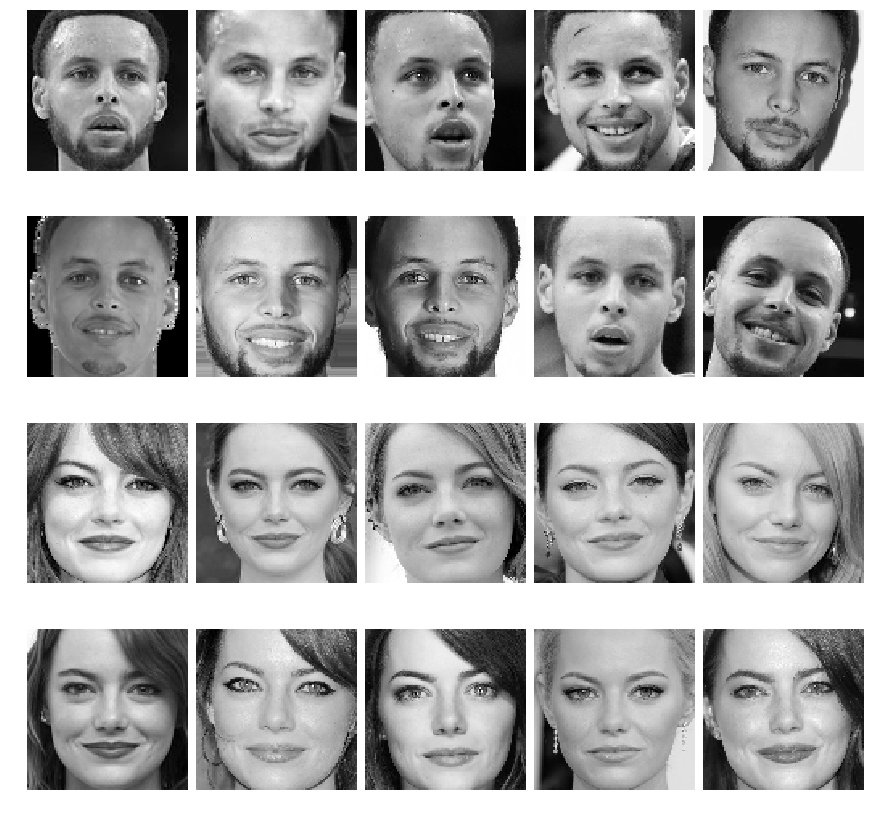

In [4]:
NUM_EIGEN_FACES = 20
K = 15
faces = []
for p in range(1, 3):
    for i in range(10):
        img = cv2.imread("./DB/person{}_{}.jpg".format(p, i), cv2.IMREAD_GRAYSCALE)
        crop = crop_face(img)
        faces.append(crop)
sz = faces[0].shape
data = np.zeros((len(faces), sz[0] * sz[1]), dtype=np.uint8)
for i in range(len(faces)):
    data[i, :] = faces[i].flatten()
f, axs = plt.subplots(4,5, figsize=(15,15))
plt.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(4):
    for j in range(5):
        axs[i,j].imshow(faces[i*5+j], cmap=plt.cm.gray)
        axs[i,j].axis('off')

#### PCA 
During PCA the mean of the face images and the eigenvalues, eigenvectors are computed

In [5]:
mean_im, eigenVectors = cv2.PCACompute(data, mean=None, maxComponents=NUM_EIGEN_FACES)
eigenFaces = []
for eigenVector in eigenVectors:
    eigenFace = eigenVector.reshape(sz)
    eigenFaces.append(eigenFace)
averageFace = mean_im.reshape(sz)

Text(0.5, 1.0, 'Mean')

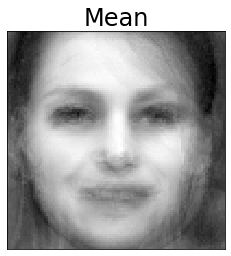

In [36]:
fig = plt.figure()
imgplot=plt.imshow(averageFace, cmap='gray')
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
imgplot.axes.set_title('Mean', fontsize = 24)

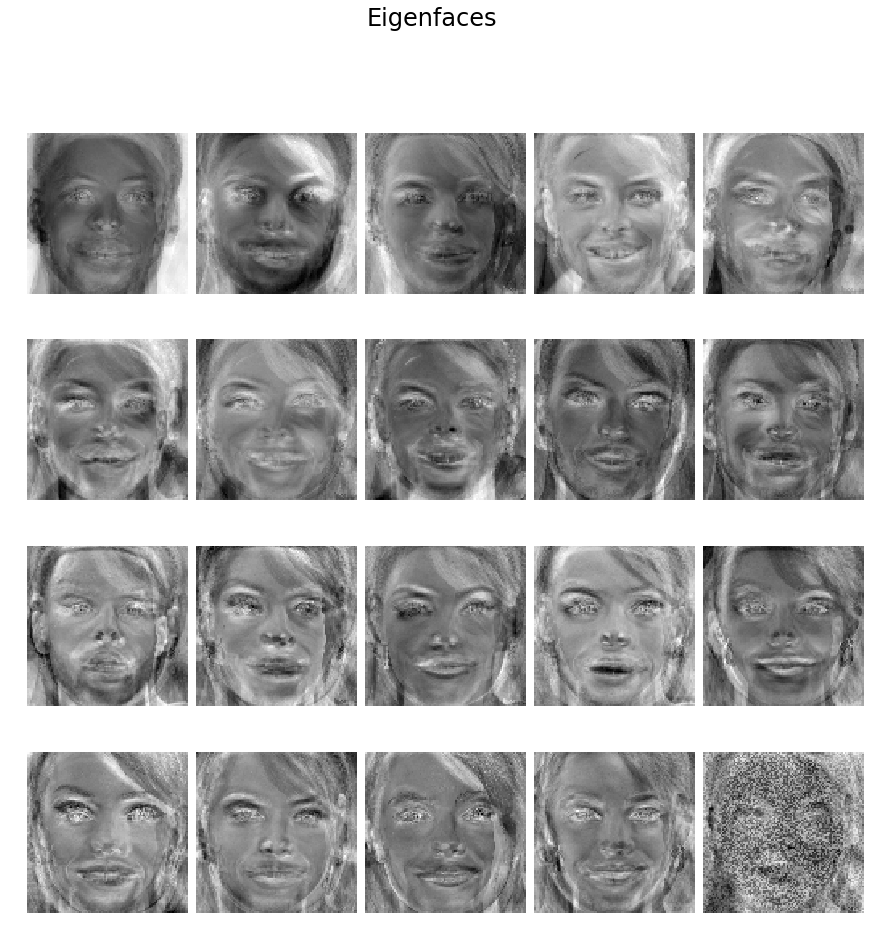

In [7]:
f, axs = plt.subplots(4,5, figsize=(15,15))
plt.subplots_adjust(hspace=0.05, wspace=0.05)
f.suptitle('Eigenfaces', fontsize=24)
for i in range(4):
    for j in range(5):
        axs[i,j].imshow(eigenFaces[i*5+j], cmap=plt.cm.gray)
        axs[i,j].axis('off')

#### Reconstruction of faces
Here, run the cell below and in the pop-up window my face and all faces from the database can be recontructed. The upper slider defines the face to be reconstructed (face 0 is mine, the following faces are from the database), the lower defines the number of eigenfaces used. My face couldn't be reconstucted very well, but the faces from DB were recognizable by using ~15 eigenfaces so I use 15 as optimal number for the reconstruction.
Close the window by pressing 'q'

In [37]:
output = averageFace
img = cv2.imread("./DB/special/my_face.jpg", cv2.IMREAD_GRAYSCALE)
my_face = crop_face(img)
rec_faces = faces.copy()
rec_faces.insert(0,my_face)
slider = 0
cv2.namedWindow("Result", cv2.WINDOW_NORMAL)
cv2.resizeWindow('Result', 600, 600)
cv2.createTrackbar("Image", "Result", 0, len(faces), reconstructFace)
cv2.createTrackbar("NumofEigFaces", "Result", 0, NUM_EIGEN_FACES, reconstructFace)
cv2.imshow("Result", output.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Face-feature plot
Here, the face images are projected to the space of the first 15 eigenfaces and then these reconstucted face images are plotted at the position of their weights corresponding to the first 2 eigenfaces
These two persons are very different, one being a woman with light skin color, and the other a man with darker skin colorand as can be seen from the figure in the space of the first 2 eigenfaces the categories are linearly separable.

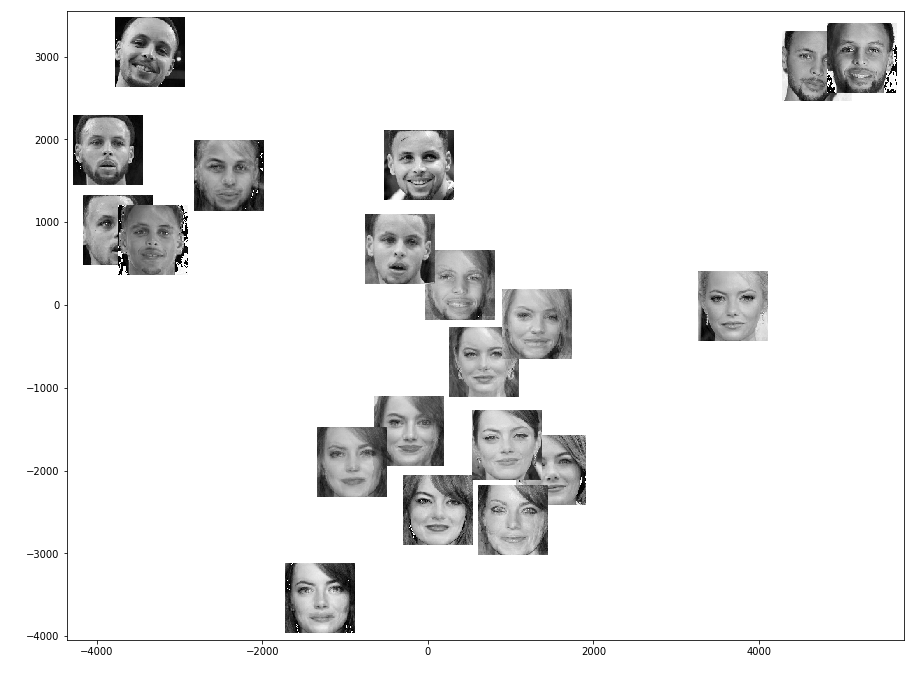

In [27]:
faces_K = []
for i in range(len(faces)):
    res = averageFace
    imVector = faces[i].flatten() - mean_im
    for j in range(0, K):
        res = res + eigenFaces[j] * np.dot(imVector, eigenVectors[j])
    res = res.astype(np.uint8)
    faces_K.append(res)
label = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
weights = np.zeros((K, len(faces)))
for i in range(len(faces)):
    for j in range(K):
        weights[j, i] = np.dot(faces[i].flatten() - mean_im, eigenVectors[j])

fig = plt.gcf()
fig.set_size_inches(15,15, forward=True)
fig.clf()
ax = plt.subplot(111)
ax.set_xlim(min(weights[0, :]) - 500, max(weights[0, :]) + 500)
ax.set_ylim(min(weights[1, :]) - 500, max(weights[1, :]) + 500)
ax.set_xlabel('eigenface1', color='white', fontsize=16)
ax.set_ylabel('eigenface2', color='white', fontsize=16)
ax.set_aspect(1.0)
for i in range(len(faces)):
    imagebox = OffsetImage(cv2.cvtColor(faces_K[i], cv2.COLOR_GRAY2RGB), zoom=.7)
    xy = [weights[0, i], weights[1, i]]
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    ax.add_artist(ab)

#### Loading the test images

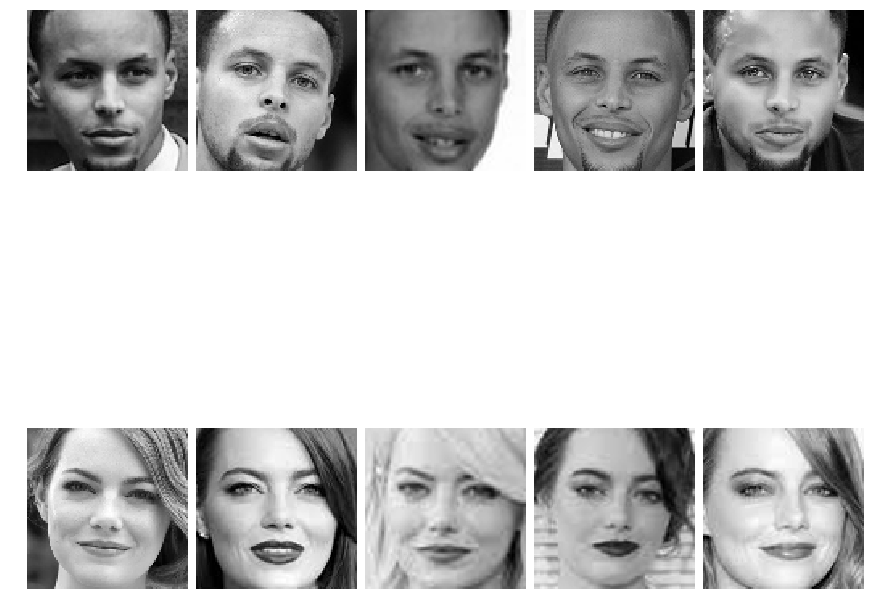

In [10]:
testfaces = []
testlabel = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
test_weights = np.zeros((K, 10))
for p in range(1, 3):
    for i in range(5):
        img = cv2.imread("./DB/test/person{}_{}.jpg".format(p, 11 + i), cv2.IMREAD_GRAYSCALE)
        crop = crop_face(img)
        testfaces.append(crop)
        for j in range(K):
            test_weights[j, (p - 1) * 5 + i] = np.dot(testfaces[(p - 1) * 5 + i].flatten() - mean_im, eigenVectors[j])
testfaces_K = []
for i in range(len(testfaces)):
    res = averageFace
    imVector = testfaces[i].flatten() - mean_im
    for j in range(0, K):
        res = res + eigenFaces[j] * np.dot(imVector, eigenVectors[j])
    res = res.astype(np.uint8)
    testfaces_K.append(res)
f, axs = plt.subplots(2,5, figsize=(15,15))
plt.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(testfaces[i*5+j], cmap=plt.cm.gray)
        axs[i,j].axis('off')

#### Showing the test images (color coded) on the face-feature plot

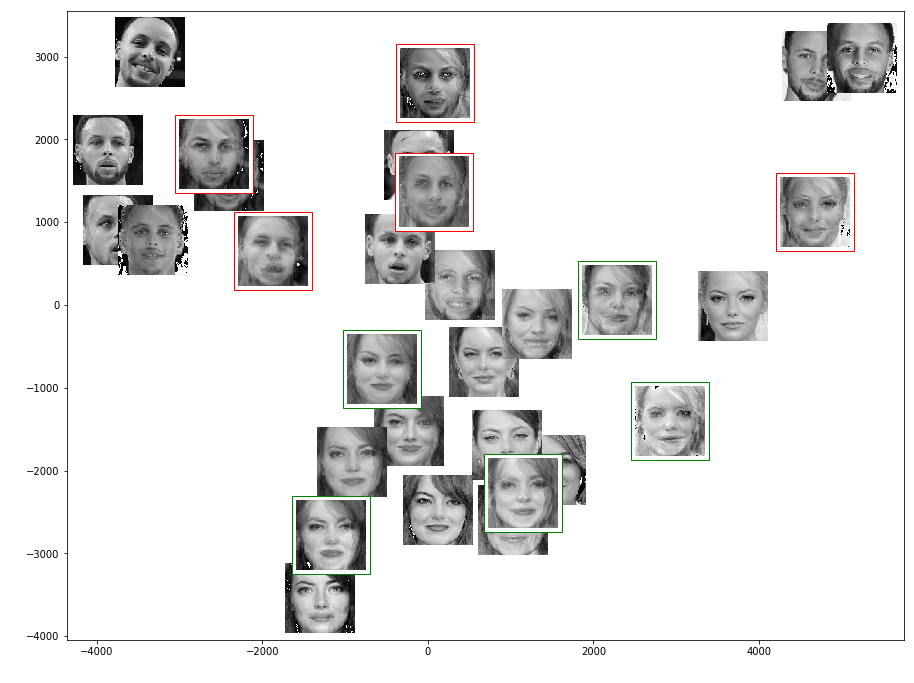

In [28]:
fig = plt.gcf()
fig.set_size_inches(15,15, forward=True)
fig.clf()
ax = plt.subplot(111)
ax.set_xlabel('eigenface1',color='white', fontsize=16)
ax.set_ylabel('eigenface2', color='white', fontsize=16)
min_x_d = min(weights[0, :])
min_x_t = min(test_weights[0, :])
min_y_d = min(weights[1, :])
min_y_t = min(test_weights[1, :])
max_x_d = max(weights[0, :])
max_x_t = max(test_weights[0, :])
max_y_d = max(weights[1, :])
max_y_t = max(test_weights[1, :])
ax.set_xlim(min(min_x_d, min_x_t) - 500, max(max_x_d, max_x_t) + 500)
ax.set_ylim(min(min_y_d, min_y_t) - 500, max(max_y_d, max_y_t) + 500)
ax.set_aspect(1.0)
for i in range(len(faces)):
    imagebox = OffsetImage(cv2.cvtColor(faces_K[i], cv2.COLOR_GRAY2RGB), zoom=.7)
    xy = [weights[0, i], weights[1, i]]
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    ax.add_artist(ab)
for i in range(len(testfaces)):
    imagebox = OffsetImage(cv2.cvtColor(testfaces_K[i], cv2.COLOR_GRAY2RGB), zoom=.7)
    xy = [test_weights[0, i], test_weights[1, i]]
    if testlabel[i] == 0:
        ab = AnnotationBbox(imagebox, xy, frameon=True, bboxprops=dict(edgecolor='red'))
    else:
        ab = AnnotationBbox(imagebox, xy, frameon=True, bboxprops=dict(edgecolor='green'))
    ax.add_artist(ab)
plt.draw()
plt.show()

Data definition for the classification methods

In [29]:
x_train = weights.transpose()
y_train = label
x_test = test_weights.transpose()
y_test = testlabel

#### Classification methods

First, I tried a simple nearest neighbour method where the label assigned for a test image is the label of the closest training image in the space of the first 15 eigenfaces. This method gave an accuracy of 90%.

In [13]:
neigh = KNeighborsClassifier(n_neighbors=1).fit(x_train, y_train)
score = neigh.score(x_test, y_test)
print('1 Nearest neighbour classifier accuracy:  %2.1f%%' % (score * 100))

1 Nearest neighbour classifier accuracy:  90.0%


The second method I tried was a simple decision tree that gave 100% accuracy.

In [14]:
dec_tree = DecisionTreeClassifier(max_depth=5).fit(x_train, y_train)
score = dec_tree.score(x_test, y_test)
print('Decision tree classifier accuracy:  %2.1f%%' % (score * 100))

Decision tree classifier accuracy:  100.0%


As I mentioned previously, the face images seemed to be linearly separable in the space of the first 2 eigenfaces so here, I used an SVM classification and this gave 100% accuracy.

In [15]:
svm = LinearSVC(max_iter=400).fit(weights[0:2, :].transpose(), y_train)
score = svm.score(test_weights[0:2, :].transpose(), y_test)
print('SVM classifier accuracy:  %2.1f%%' % (score * 100))

SVM classifier accuracy:  100.0%


To see what breaks my classifiers, I tried a face not looking into the camera and this was not classified correctly.

0.0


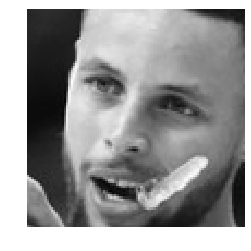

In [16]:
img = cv2.imread("./DB/special/person1_new.jpg", cv2.IMREAD_GRAYSCALE)
cat = [0]
crop = crop_face(img)
plt.imshow(crop, cmap=plt.cm.gray)
plt.axis('off')
w = np.zeros((K, 1))
for j in range(K):
    w[j, 0] = np.dot(crop.flatten() - mean_im, eigenVectors[j])
print(neigh.score(w.transpose(),cat)*100)

In the following 2 images, no faces were found.

No face detected


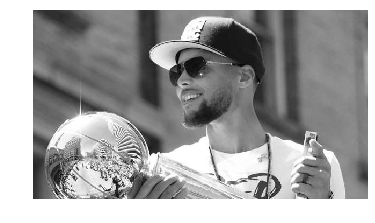

In [17]:
img = cv2.imread("./DB/special/person1_sunglasses.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
cat = [0]
crop = crop_face(img)

No face detected


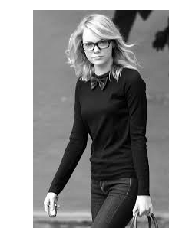

In [18]:
img = cv2.imread("./DB/special/person2_glasses.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
cat = [1]
crop = crop_face(img)

And this face is also classified incorrectly, probably because the person wears a cap.

0.0


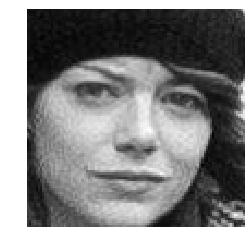

In [19]:
img = cv2.imread("./DB/special/person2_scarf.jpg", cv2.IMREAD_GRAYSCALE)
cat = [1]
crop = crop_face(img)
plt.imshow(crop, cmap=plt.cm.gray)
plt.axis('off')
w = np.zeros((K, 1))
for j in range(K):
    w[j, 0] = np.dot(crop.flatten() - mean_im, eigenVectors[j])
print(dec_tree.score(w.transpose(),cat)*100)

To improve the nearest neighbour method, I extended it to the 3 nearest neighbours and this indeed improved the results, gave 100% accuracy.

In [23]:
neigh3 = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)
score = neigh3.score(x_test, y_test)
print('3 Nearest neighbour classifier accuracy:  %2.1f%%' % (score * 100))

3 Nearest neighbour classifier accuracy:  100.0%
